# Load data

In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



MC_DATA_FOLDER = '../results/MC_data_1e7'
TOTAL_NUMBER_OF_ANNIHILATIONS = 10_000_000
TOTAL_NUMBER_OF_PHOTONS = TOTAL_NUMBER_OF_ANNIHILATIONS * 2
Rs = [5.0, 10.0,15.0]
scatter_tbls  = {}
lor_tbls = {}

for R in Rs:
    try:
        lor_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/lors_*_R{int(R)}.feather"))
        phot_files = sorted(glob.glob(f"{MC_DATA_FOLDER}/photons_*_R{int(R)}.feather"))

        lors_df = pd.concat((pd.read_feather(f) for f in lor_files), ignore_index=True)
        photons_df = pd.concat((pd.read_feather(f) for f in phot_files), ignore_index=True)
        print(f"R={R}")
        print('Number of LORs:', len(lors_df),"Number of photons", len(photons_df))
        scatter_tbls[R] = photons_df
        lor_tbls[R] = lors_df
    except Exception as e:
        print(e)


R=5.0
Number of LORs: 9931300 Number of photons 20000000
R=10.0
Number of LORs: 9389901 Number of photons 20000000
R=15.0
Number of LORs: 8324892 Number of photons 20000000


# Gain vs FWHM plot
Note! This takes approx. 4-5 min. to run on my computer.

In [2]:
def hwhm(d, edges, return_err=True, err_mode="half_bin"):
    """
    HWHM from counts histogram (d>=0). Returns (hwhm, err) or hwhm.
    corresponding to the d_1/2 value.
    """
    d = np.asarray(d, float)
    d = d[np.isfinite(d)]
    d = d[d >= 0.0]
    if d.size < 50: #to few data points, important when bootstrapping
        return (np.nan, np.nan) if return_err else np.nan

    counts, _ = np.histogram(d, bins=edges)
    centers = 0.5*(edges[:-1] + edges[1:])
    bw = float(edges[1] - edges[0]) if len(edges) >= 2 else np.nan # bin width, with fast fail

    i_peak = int(np.argmax(counts)) # index of peak, is 0 but makeing it consitent this way
    cmax = counts[i_peak] # maximum count
    if cmax <= 0: # fail safe
        return (np.nan, np.nan) if return_err else np.nan

    half = 0.5 * cmax # half maximum
    post = counts[i_peak:] # post-peak counts
    below = np.where(post <= half)[0] # indices where counts go below half max
    if below.size == 0: # fail safe
        return (np.nan, np.nan) if return_err else np.nan
    i2 = i_peak + int(below[0])     # index where counts go below half max

    
    x1, y1 = centers[i2-1], counts[i2-1] # point before crossing
    x2, y2 = centers[i2],   counts[i2] # point after crossing
    if y2 == y1: # horizontal line case
        h = float(x2)
    else:   # linear interpolation
        h = float(x1 + (half - y1) * (x2 - x1) / (y2 - y1))

    if not return_err: # earlier I used the bin width as error estimate, but changed later to bootstrap so this returns only the h-value aerlier
        return h

    # The below errors are not used in the final analysis, kept here for reference
    if err_mode == "half_bin":
        err = 0.5 * bw
    elif err_mode == "one_bin":
        err = 1.0 * bw
    else:
        raise ValueError("err_mode must be 'half_bin' or 'one_bin'")

    return h, float(err)
def hwhm_bootstrap_ci(
    d,
    edges,
    quantiles_low_high=(0.025, 0.975),
    n_boot=300,
    rng_seed=123,
    min_n=30,
    min_keep_frac=0.33,
    min_keep_abs=10,
):
    rng = np.random.default_rng(rng_seed)

    d = np.asarray(d, float)
    d = d[np.isfinite(d)]
    d = d[d >= 0.0]
    n = d.size
    if n < min_n: # fail safe, for debugging
        return np.nan, (np.nan, np.nan)

    vals = []
    for _ in range(int(n_boot)): # for each bootstrap sample
        ds = rng.choice(d, size=n, replace=True)
        h = hwhm(ds, edges, return_err=False) # get HWHM without error
        vals.append(h)

    min_keep = max(int(min_keep_frac * n_boot), int(min_keep_abs)) # minimum number of valid bootstrap samples to keep
    if len(vals) < min_keep: # fail safe for debugging
        return np.nan, (np.nan, np.nan)

    # get statistics from the bootstrap samples
    vals = np.asarray(vals, float) 
    h_mean = float(np.mean(vals))
    lo, hi = np.quantile(vals, quantiles_low_high)
    return h_mean, (float(lo), float(hi))


In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

COLUMNWIDTH_PT = 242.5389 # from LaTeX \the\columnwidth printout to make the figuresize match the paper
INCH_PER_PT = 1 / 72.27 # inches per pt, common conversion factor
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT 
FIG_H = FIG_W * 2.6  # for aspect ratio

Rs = [5.0, 10.0, 15.0]  # cm

energy_thresholds = np.array([510, 500, 490, 480, 470, 460, 450, 440, 430, 420, 410, 400], float) # keV

DMAXS = [3.0, 5.0, 7.0]     # used for histogram xlims in the different R cases
BIN_WIDTH = 0.05 # cm
BINS = int((DMAXS[-1]) / BIN_WIDTH) + 1  # number of bins for histograms

N_BOOT = 500                # bootstrap samples for CI

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.85
eth_colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(energy_thresholds)))

# Matplotlib styling 
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.5,
    "grid.color": "white",
    "axes.facecolor": "whitesmoke",
})



In [4]:
from tqdm import tqdm

tbl_by_R = {}
for i, (R, dmax) in tqdm(enumerate(zip(Rs, DMAXS)), total=len(Rs), desc="Processing R values"):
    lor = lor_tbls[R]

    # Use a common binning for HWHM
    d_all = lor["lor_dist_to_point_cm"].to_numpy(float)
    edges = np.linspace(0.0, DMAXS[-1], BINS) # Use same bins for all R

    baseline_mask = (lor["n_scatter_p1"] == 0) & (lor["n_scatter_p2"] == 0)
    N_unscattered = int(baseline_mask.sum()) # number of unscattered annihilation pairs LORs

    rows = []
    for Eth in energy_thresholds:
        m = (lor["exit_energy_1_keV"] >= Eth) & (lor["exit_energy_2_keV"] >= Eth)

        # exclude non-scattered annihilation pairs
        d = lor.loc[m, "lor_dist_to_point_cm"]
        d = d[~baseline_mask & d.notna()].to_numpy(float)

        N_extra = int(d.size)
        gain_pct = (N_extra / N_unscattered * 100.0) if N_unscattered > 0 else np.nan

        # get HWHM with bootstrap and 95% CI
        HWHM, (H_lo, H_hi) = hwhm_bootstrap_ci(d, edges, n_boot=N_BOOT, quantiles_low_high=[0.005, 0.995])
        FWHM = 2.0 * HWHM
        F_lo, F_hi = 2.0 * H_lo, 2.0 * H_hi # error propagation

        rows.append({
            "Eth_keV": float(Eth),
            "N_extra": N_extra,
            "N_unscattered": N_unscattered,
            "Gain_%": float(gain_pct),
            "FWHM_cm": float(FWHM),
            "FWHM_lo_cm": float(F_lo),
            "FWHM_hi_cm": float(F_hi),
        })

    tbl = pd.DataFrame(rows).sort_values("Eth_keV", ascending=False).reset_index(drop=True)
    tbl_by_R[R] = tbl


for R in Rs:
    tbl = tbl_by_R[R]
    print(f"\n--- R={R:.0f} cm ---")
    print(tbl[["Eth_keV", "N_extra", "Gain_%", "FWHM_cm", "FWHM_lo_cm", "FWHM_hi_cm"]].to_string(index=False))



Processing R values: 100%|██████████| 3/3 [02:43<00:00, 54.42s/it]


--- R=5 cm ---
 Eth_keV  N_extra    Gain_%  FWHM_cm  FWHM_lo_cm  FWHM_hi_cm
   510.0    18494  0.641970 0.185896    0.178647    0.193050
   500.0   133261  4.625803 0.533699    0.515780    0.552564
   490.0   249524  8.661565 0.770375    0.744751    0.791684
   480.0   366332 12.716245 0.971800    0.946365    0.991031
   470.0   482628 16.753152 1.127294    1.105688    1.150177
   460.0   599774 20.819566 1.294164    1.268734    1.316976
   450.0   716809 24.882126 1.442047    1.415830    1.469351
   440.0   835004 28.984952 1.586835    1.545035    1.623766
   430.0   953692 33.104891 1.728400    1.705144    1.752272
   420.0  1072297 37.221950 1.841882    1.815822    1.867831
   410.0  1191137 41.347166 1.966725    1.935699    1.997837
   400.0  1310670 45.496437 2.098180    2.068971    2.127709

--- R=10 cm ---
 Eth_keV  N_extra    Gain_%  FWHM_cm  FWHM_lo_cm  FWHM_hi_cm
   510.0    12297  1.247322 0.312207    0.272780    0.351146
   500.0    88611  8.988084 0.994524    0.945502    

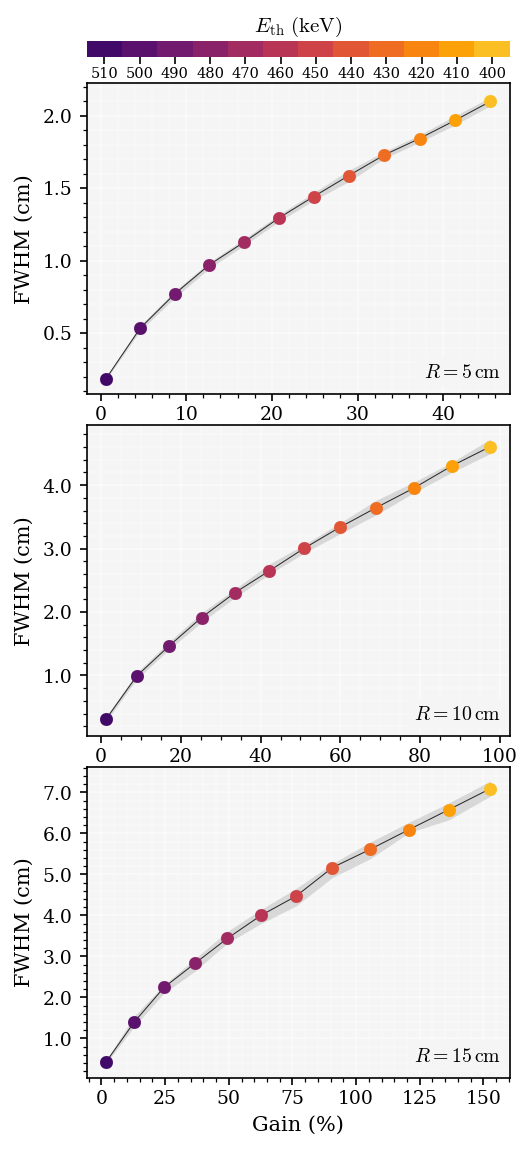

In [5]:
import numpy as np
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt


fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=False)
fig.subplots_adjust(
    left=0.14,
    right=0.98,
    bottom=0.1,   
    top=0.86,     
    hspace=0.1
)

# Unit tag placement
PCT_TAG_Y = -0.0
GAIN_LABEL_Y = -0.12 

eth_to_idx = {float(E): j for j, E in enumerate(energy_thresholds)}

for i, R in enumerate(Rs):
    ax = axes[i]
    tbl = tbl_by_R[R]

    # data
    x = tbl["Gain_%"].to_numpy(float)
    y = tbl["FWHM_cm"].to_numpy(float)
    lo = tbl["FWHM_lo_cm"].to_numpy(float)
    hi = tbl["FWHM_hi_cm"].to_numpy(float)
    eths = tbl["Eth_keV"].to_numpy(float)

    # sort by gain
    order = np.argsort(x)
    x2, y2, lo2, hi2, eths2 = x[order], y[order], lo[order], hi[order], eths[order]

    ok = np.isfinite(x2) & np.isfinite(y2) & np.isfinite(lo2) & np.isfinite(hi2)
    x2, y2, lo2, hi2, eths2 = x2[ok], y2[ok], lo2[ok], hi2[ok], eths2[ok]
    if x2.size == 0:
        ax.text(0.5, 0.5, "No finite data", transform=ax.transAxes, ha="center", va="center")
        continue

    # plot
    ax.fill_between(x2, lo2, hi2, color="black", alpha=0.12, linewidth=0, zorder=1)
    ax.plot(x2, y2, "-", color="black", linewidth=0.5, zorder=2, alpha=0.8)

    for xx, yy, Eth in zip(x2, y2, eths2):
        j = eth_to_idx.get(float(Eth), None)
        col = eth_colors[j] if j is not None else "black"
        ax.scatter(xx, yy, s=38, color=col, edgecolor=None, linewidth=0.1, zorder=7)

    # Some styling
    ax.set_ylabel("FWHM (cm)")
    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    # 1 decimal everywhere
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))
    ax.tick_params(axis="x", which="major", pad=2)

    ax.set_xlabel("")

    if i == 2:
        ax.text(
            0.5, GAIN_LABEL_Y, "Gain (%)",
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=10,
            clip_on=False,
        )

    ax.text(
        0.98, 0.04,
        rf"$R={R:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9.5,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

# Shared colorbar
N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(eth_colors), norm=norm)
sm.set_array([])

top_pos = axes[0].get_position()
cbar_h = 0.012
gap = 0.020
cax = fig.add_axes([top_pos.x0, top_pos.y1 + gap, top_pos.width, cbar_h])

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    ticks=np.arange(N) + 0.5,
    drawedges=False,
)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}~\mathrm{(keV)}$", fontsize=10, labelpad=4.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.tick_params(axis="x", labelsize=7, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

# Save
plt.savefig("fwhm_vs_gain_all_R.pdf", transparent=False)
plt.savefig("fwhm_vs_gain_all_R.svg", transparent=False)
fig.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)
fig.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R.svg",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)


# All $R$

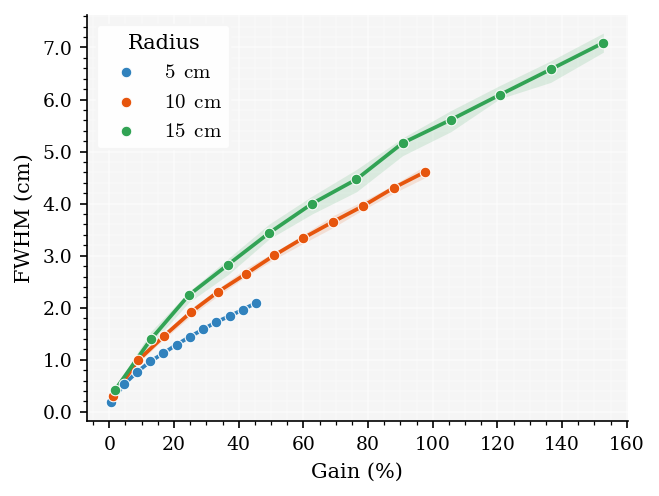

In [19]:
line_colors = {
    5:  "#3182bd",   # darker blue
    10: "#e6550d",   # darker orange
    15: "#31a354",   # darker green
}

fig2, ax2 = plt.subplots(figsize=(FIG_W*1.25, FIG_W*0.95))
fig2.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.97)

for R in sorted(tbl_by_R.keys(), key=float):
    tbl = tbl_by_R[R]
    col = line_colors.get(int(round(float(R))), "black")

    x   = tbl["Gain_%"].to_numpy(float)
    y   = tbl["FWHM_cm"].to_numpy(float)
    lo  = tbl["FWHM_lo_cm"].to_numpy(float)
    hi  = tbl["FWHM_hi_cm"].to_numpy(float)
    
    order = np.argsort(x)
    x2, y2, lo2, hi2 = x[order], y[order], lo[order], hi[order]
    ax2.fill_between(
        x2, lo2, hi2,
        color=col, alpha=0.14, linewidth=0, zorder=1
    )

    ax2.plot(
        x2, y2,
        "-", color=col, linewidth=1.8, zorder=2
    )

    ax2.scatter(
        x2, y2,
        s=26, color=col, edgecolor="white", linewidth=0.5,
        zorder=3, label=rf"${int(round(float(R)))}\,~\mathrm{{cm}}$"
    )


ax2.set_xlabel("Gain (%)")
ax2.set_ylabel("FWHM (cm)")

# Tick formatting
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))

ax2.minorticks_on()
ax2.grid(True, which="major")
ax2.grid(True, which="minor", alpha=0.25, linewidth=0.8)

leg = ax2.legend(
    title="Radius",
    loc="upper left",
    frameon=True,
)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("whitesmoke")
leg.get_frame().set_alpha(0.95)

for sp in ("top", "right"):
    ax2.spines[sp].set_visible(False)

fig2.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R_combined_percentage.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)
fig2.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R_combined_percentage.svg",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)


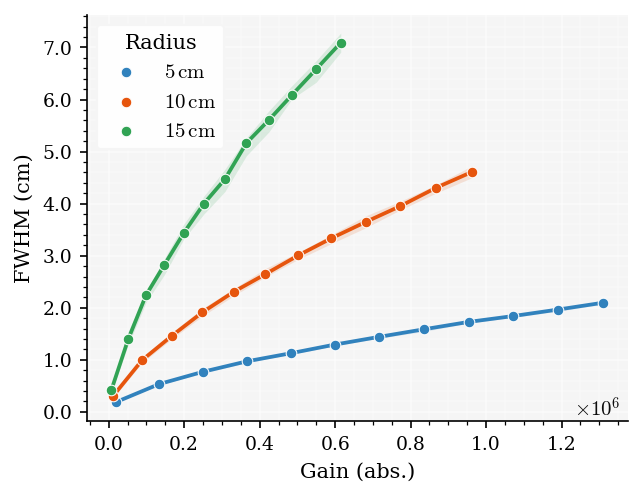

In [15]:
import numpy as np
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt

line_colors = {
    5:  "#3182bd",   # darker blue
    10: "#e6550d",   # darker orange
    15: "#31a354",   # darker green
}

fig2, ax2 = plt.subplots(figsize=(FIG_W*1.25, FIG_W*0.95))
fig2.subplots_adjust(left=0.12, right=0.98, bottom=0.12, top=0.97)

for R in sorted(tbl_by_R.keys(), key=float):
    tbl = tbl_by_R[R]
    col = line_colors.get(int(round(float(R))), "black")

    x   = tbl["N_extra"].to_numpy(float)         # ABSOLUTE gain
    y   = tbl["FWHM_cm"].to_numpy(float)
    lo  = tbl["FWHM_lo_cm"].to_numpy(float)
    hi  = tbl["FWHM_hi_cm"].to_numpy(float)

    order = np.argsort(x)
    x2, y2, lo2, hi2 = x[order], y[order], lo[order], hi[order]

    ax2.fill_between(x2, lo2, hi2, color=col, alpha=0.14, linewidth=0, zorder=1)
    ax2.plot(x2, y2, "-", color=col, linewidth=1.8, zorder=2)

    ax2.scatter(
        x2, y2,
        s=26, color=col, edgecolor="white", linewidth=0.5,
        zorder=3, label=rf"${int(round(float(R)))}\,\mathrm{{cm}}$"
    )

# Labels
ax2.set_xlabel("Gain (abs.)")   # absolute gain
ax2.set_ylabel("FWHM (cm)")
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f"))


# scientific notation with ×10^x on x-axis to the right
sf = mticker.ScalarFormatter(useMathText=True)
sf.set_scientific(True)
sf.set_powerlimits((0, 0))
ax2.xaxis.set_major_formatter(sf)

# force formatter to decide exponent
fig2.canvas.draw()

oom = ax2.xaxis.get_major_formatter().orderOfMagnitude
ax2.xaxis.offsetText.set_visible(False)   # hide Matplotlib offset text

scale = (10.0 ** oom) if oom != 0 else 1.0

# replace tick labels by scaled decimals
ax2.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda v, pos, s=scale: f"{(v/s):.1f}")
)

# draw ×10^oom 
if oom != 0:
    ax2.text(
        0.9, +0.06, rf"$\times 10^{{{oom}}}$",
        transform=ax2.transAxes,
        ha="left", va="top",
        fontsize=10,
        clip_on=False,
        alpha=0.95,
    )

# Styling
ax2.minorticks_on()
ax2.grid(True, which="major")
ax2.grid(True, which="minor", alpha=0.25, linewidth=0.8)

leg = ax2.legend(title="Radius", loc="upper left", frameon=True)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("whitesmoke")
leg.get_frame().set_alpha(0.95)

for sp in ("top", "right"):
    ax2.spines[sp].set_visible(False)

# Save
fig2.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R_combined_absolute.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)
fig2.savefig(
    "../results/figures/gain_vs_fwhm/fwhm_vs_gain_all_R_combined_absolute.svg",
    bbox_inches="tight",
    pad_inches=0.02,
    transparent=False,
)

